# Оптимизация поиска

В этом занятии вы узнаете, как сделать более качественный поиск релевантных документов или чанков. Ведь именно от этого зависит end-to-end качество вашей RAG-системы. Разберем использование моделей типа `BM25` для более полного поиска, а также cross-encoders для ранжировки результатов.

In [ ]:
%%capture
!pip install datasets==3.6.0 fsspec==2025.3.0 transformers==4.52.4 huggingface_hub==0.33.0 qdrant_client langchain_community

In [ ]:
import re
import uuid
import torch

import numpy as np

from tqdm.auto import tqdm

from datasets import load_dataset
from langchain_community.cross_encoders import HuggingFaceCrossEncoder
from langchain.text_splitter import RecursiveCharacterTextSplitter
from sentence_transformers import SentenceTransformer
from transformers import pipeline
from qdrant_client import QdrantClient, models

### Загрузка датасета и модели



Данные: [blinoff/kinopoisk](https://huggingface.co/datasets/blinoff/kinopoisk)


> Kinopoisk movie reviews dataset (TOP250 & BOTTOM100 rank lists).
  In total it contains 36,591 reviews from July 2004 to November 2012.



In [ ]:
def process_dataset(sample):
    sample['content'] = sample['content'].replace('\xa0', ' ')
    return sample

dataset = load_dataset("blinoff/kinopoisk", split='train')
dataset = dataset.map(process_dataset)

dataset

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

kinopoisk.jsonl:   0%|          | 0.00/143M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/36591 [00:00<?, ? examples/s]

Map:   0%|          | 0/36591 [00:00<?, ? examples/s]

Dataset({
    features: ['part', 'movie_name', 'review_id', 'author', 'date', 'title', 'grade3', 'grade10', 'content'],
    num_rows: 36591
})

In [ ]:
dataset[0]

{'part': 'top250',
 'movie_name': 'Блеф (1976)',
 'review_id': '17144',
 'author': 'Come Back',
 'date': datetime.datetime(2011, 9, 24, 0, 0),
 'title': 'Плакали наши денежки ©',
 'grade3': 'Good',
 'grade10': '10',
 'content': '\n"Блеф» — одна из моих самых любимых комедий.\n\nЭтот фильм я наверно смотрел раз сто, нет я конечно блефую, я видел его куда больше. Не могу не выразить своё восхищение главными действующими лицами этого фильма. Начну с Адриано Челентано для которого как я считаю это лучшая роль в кино. Великолепный актёр, неплохой певец, странно что на его родине в Италии его песни мало кто слушает. Ну я думаю что и итальянцы и французы привыкли к тому, что у нас до сих их актёры популярней чем даже на своей родине. Да, такой вот парадокс. Челентано конечно профессионал своего дела, комик с серьёзным выражением лица. Он смешон ещё и потому, что одновременно так серъёзен. Адриано браво!\n\nА теперь несколько слов об Энтони Куине. Да тот самый горбун из Нотр-дама. Собор Парижс

В качестве основной модели возьмем [Qwen2-1.5B-Instruct](https://huggingface.co/Qwen/Qwen2-1.5B-Instruct)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

generation_pipeline = pipeline(
    "text-generation",
    model="Qwen/Qwen2-1.5B-Instruct",
    device=device,
    torch_dtype=torch.float16
)

config.json:   0%|          | 0.00/660 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cuda


## QA без RAG

Проверим, насколько хорошо модель отвечает на вопросы без использования RAG.

In [ ]:
def get_answer(query):
  messages = [
    {"role": "user", "content": query},
  ]
  output = generation_pipeline(messages, max_new_tokens=256, do_sample=True, temperature=0.9, top_p=0.7)
  answer = output[0]['generated_text'][1]['content']
  print(answer)

In [ ]:
query = 'Какие мультфильмы были созданы студией Pixar'
get_answer(query)

С 1986 по настоящее время, студия Pixar создала множество классических и популярных мультфильмов, включая:

1. "Toy Story" (1995)
2. "Toy Story 2" (1999)
3. "Monsters Inc." (2001)
4. "Finding Nemo" (2003)
5. "Cars" (2006)
6. "Cars 2" (2007)
7. "The Incredibles" (2004)
8. "Ratatouille" (2007)
9. "Up" (2009)
10. "Zootopia" (2016)
11. "Coco" (2017)

Это лишь некоторые из множества великолепных работ студии Pixar.


In [ ]:
query = 'В каких фильмах снимался Андриано Челентано?'
get_answer(query)

Андриано Челентано был известен своими фильмами в качестве актера, режиссера и продюсера. Он снялся в следующих фильмах:

1. "Битва за Лиссабон" (1974)
2. "Джейн Фонтейн" (1980)
3. "Тайная жизнь виллы Оливы" (1981)
4. "Миссис Мерфи" (1985)
5. "Крепкий орешек" (1996)
6. "Город призраков" (2001)
7. "Наркоз" (2002) 
8. "Робокоп" (2004)
9. "Семь плашек" (2006)

Это только некоторые из его наиболее известных фильмов.


## Добавим RAG

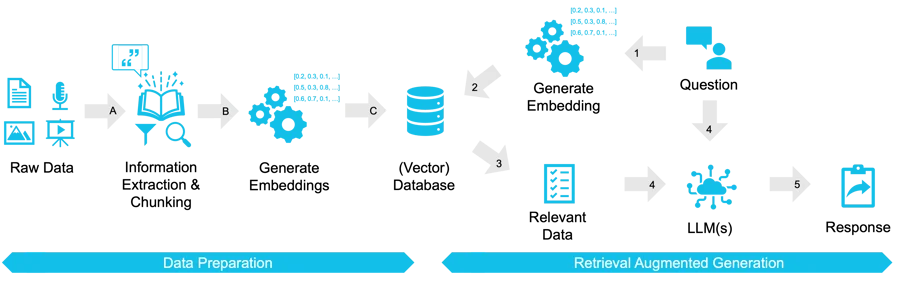

Первый шаг — наполнение векторной базы данных. В качестве модели для создания эмбеддингов возьмем [intfloat/multilingual-e5-large](https://huggingface.co/intfloat/multilingual-e5-large).

In [ ]:
embedding_model = SentenceTransformer("intfloat/multilingual-e5-base", model_kwargs={'torch_dtype': torch.float16});

modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

### Выбор векторной базы

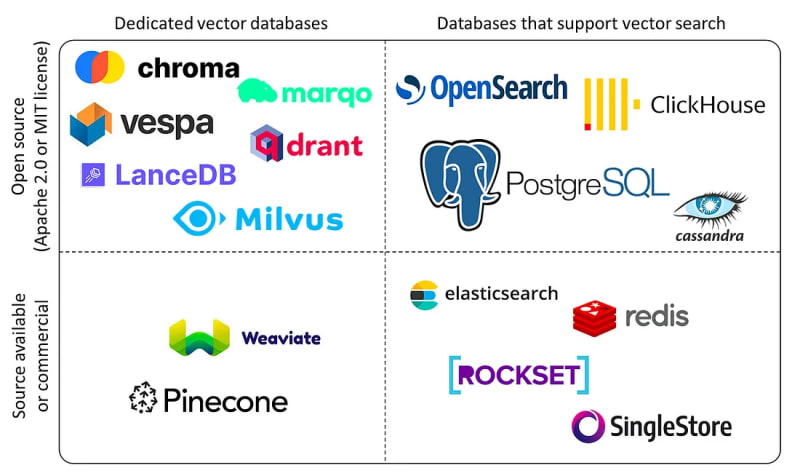

Как выбрать поисковый движок?

- Составляем список требований **в конкретном проекте**;
- собираем список кандидатов;
- составляем сводную таблицу по доступному функционалу кандидатов;
- ищем наибольшее пересечение требований и функционала в таблице.

[Vector DB Comparison](https://superlinked.com/vector-db-comparison)

### Qdrant

Построим векторную базу данных с помощью фреймворка Qdrant.

**Особенности Qdrant**:

- Предоставляет спецификации OpenAPI v3 и предварительно построенные клиенты для нескольких языков программирования.

- Использует собственный алгоритм **HNSW** для быстрого и точного поиска векторов.

- Позволяет фильтровать результаты на основе связанных векторных данных.

- Поддерживает различные типы данных, включая сопоставление строк, числовые диапазоны и географические местоположения.

- Разработан для облачных сред с возможностями горизонтального масштабирования.

[Qdrant Benchmarking Vector Databases](https://qdrant.tech/benchmarks/)

### Алгоритмы поиска векторов

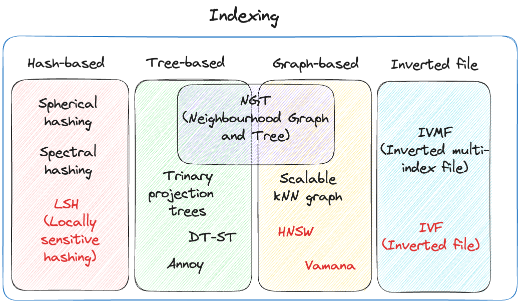

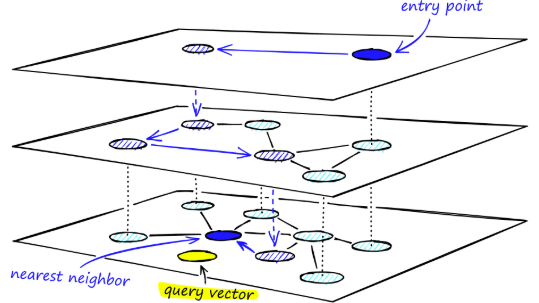

In [ ]:
client = QdrantClient(":memory:")

client.create_collection(
    collection_name="kinopoisk_e5",
    on_disk_payload=True,
    vectors_config=models.VectorParams(
        size=768,
        distance=models.Distance.COSINE,
        on_disk=True
    ),
)

True

### Как считать расстояние

- Евклидово расстояние (L2, самое популярное);
- манхэттенское расстояние (L1);
- скалярное произведение (самое интересное для векторной БД: из него можно вывести косинусную близость, а их обычно смотрят вместе);
- косинусная близость.


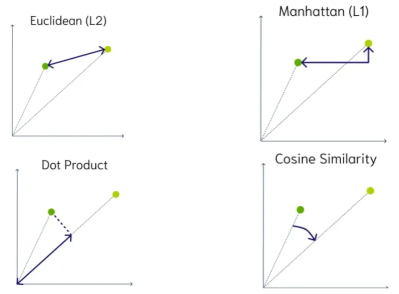

### Разбиение текста на чанки

Для разбиения текста на куски используем `RecursiveCharacterTextSplitter` из библиотеки [langchain](https://github.com/langchain-ai/langchain). Мы будем делить текст на куски примерно по 1000 символов рекурсивно.

[Какие еще есть варианты?](https://python.langchain.com/v0.1/docs/modules/data_connection/document_transformers/)

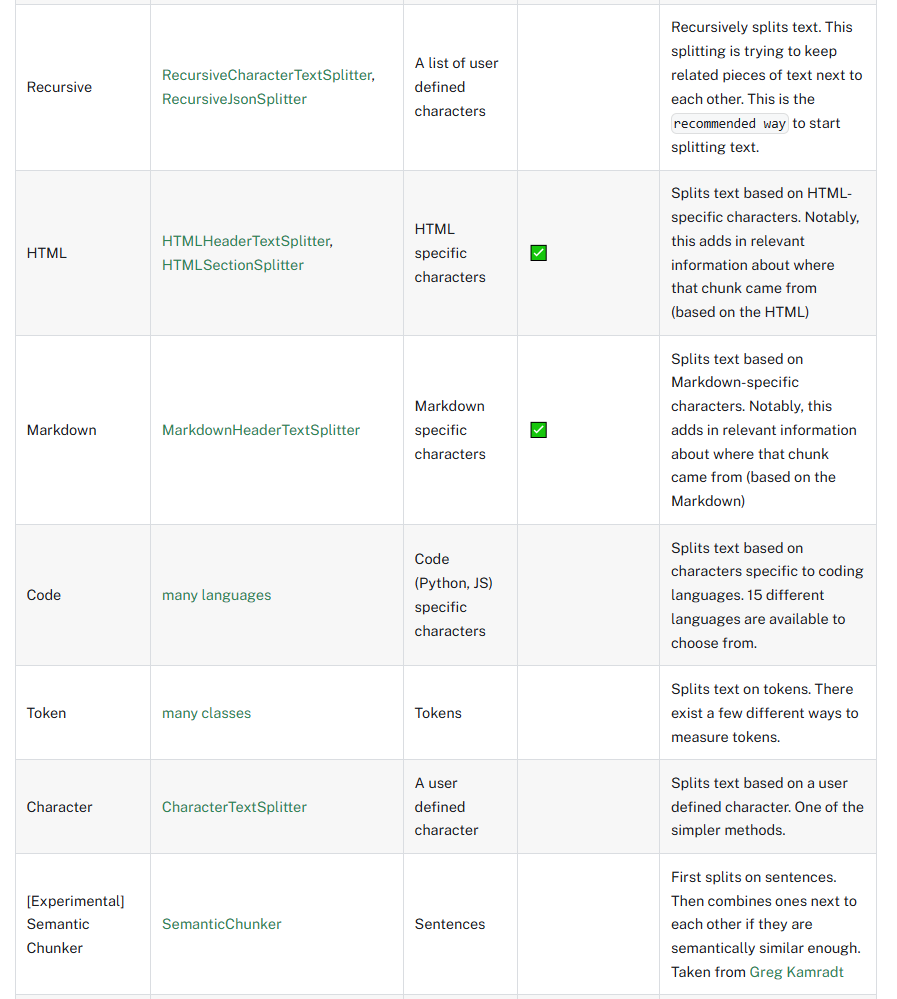

In [ ]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)

### Векторизация текстов

In [ ]:
for i in tqdm(range(len(dataset))):
    text_chunks = text_splitter.split_text(dataset[i]['content'])

    vectors = embedding_model.encode(text_chunks, normalize_embeddings=True, device=device).tolist()

    client.upsert(
        collection_name='kinopoisk_e5',
        points=[
            models.PointStruct(
                id=str(uuid.uuid4()),
                vector=vectors[j],
                payload={
                    'text': text_chunks[j],
                    'movie_name': dataset[i]['movie_name'][:-7],
                    'year': int(dataset[i]['movie_name'][-5:-1]),
                }
            )
            for j in range(len(text_chunks))
        ]
    )

100%|██████████| 36591/36591 [11:17<00:00, 54.02it/s]


Проверим, насколько хорошо ищутся похожие по смыслу тексты.

In [ ]:
query

'Как называется фильм 2004 года, в котором пожилой мужчина читает своей возлюбленной историю их молодости из записной книжки, а действие происходит в доме престарелых?'

In [ ]:
query_vector = embedding_model.encode(query, normalize_embeddings=True, device=device)

In [ ]:
hits = client.search(
    collection_name="kinopoisk_e5",
    query_vector=query_vector,
    limit=5
)

/tmp/ipython-input-86-3933116058.py:1: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  hits = client.search(


In [ ]:
[hit.payload for hit in hits]

[{'text': 'Дом престарелых в Америке. Пожилой человек читает столь же пожилой даме некий дневник, где рассказывается история про то, как бедный, но гордый юноша встретил богатую наследницу и они полюбили друг друга и смогли пройти через все испытания, включая испытание долгой разлукой вначале из-за родителей девушки, потом из-за войны. И несмотря ни на что, включая попытки существовать рядом с другими, они нашли в себе силы найти друг друга и жить вместе.\n\nНет ничего более милого, чем абсолютно прогнозируемая история взаимоотношений двух людей из разных слоев общества. Итог известен заранее, несмотря на то, что весь наш жизненный опыт говорит о другом… Так получится и в этот раз, понятно, что сентиментальные девушки будут рыдать у экрана, а их спутники будут их утешать. \n\nКак терапевтическое средство фильм вполне подойдет. Но говорить о каком-либо художественном значении этого фильма я бы не рискнул.',
  'movie_name': 'Дневник памяти',
  'year': 2004},
 {'text': 'Тронуло то, как сн

In [ ]:
def semantic_search(client, query, limit=10):
    query_vector = embedding_model.encode(
        query, normalize_embeddings=True, device=device
    ).tolist()

    hits = client.search(
        collection_name="kinopoisk_e5",
        query_vector=query_vector,
        limit=limit
    )
    relevant_chunks = [hit.payload for hit in hits]

    return relevant_chunks

### RAG на отзывах

Для реализации RAG будем передавать в контекст модели отзывы, относящиеся к запросу.

In [ ]:
def llm_answer(query, context):
    prompt = f"""
    Ты русскоязычный эксперт в области кинематографа. У тебя есть доступ к набору отзывов о фильмах, используй их, чтобы полно и точно ответить на следующий вопрос. Убедись, что ответ подробный, конкретный и непосредственно касается вопроса. Не добавляй информацию, которая не подтверждается предоставленными отзывами.

Вопрос:
{query}

Отзывы:
{context}
"""
    messages = [
        {"role": "user", "content": prompt},
    ]
    output = generation_pipeline(messages, max_new_tokens=512, do_sample=True, temperature=0.9, top_p=0.7)

    return output[0]['generated_text'][1]['content']

In [ ]:
selected_chunks = semantic_search(client, query)
context = ' ; '.join([f"\nОтзыв: {chunk['text']}" for chunk in selected_chunks])
print(context)

/tmp/ipython-input-18-1628058899.py:6: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  hits = client.search(



Отзыв: - Вы что — не смотрите на дорогу?

- Почему же, смотрю: она отражается в Ваших глазах.

«Безумно влюблённый» — еще одна замечательная, мною просмотренная комедия с легендарным Адриано Челентано. Видимо режиссерам и сценаристам Франко Кастеллано, Джузеппе Моччиа настолько понравилась экранная пара Адриано Челентано и Орнелла Мути, которая создалась в 1980 году в фильме «Укрощение строптивого», что они решили снять еще один фильм с этими потрясающими актерами. Только в этой картине наши герои поменялись местами, и теперь ухаживает и безумно влюбилась не Орнелла в Адрианно, который исполнял роль деревенского хама и грубияна Элию, а Адриано — обычный водитель автобуса по уши влюбился в прекрасную девушку-туристку, которая посетила его автобус, желая увидеть прекрасный город Рим.

- Ты меня любишь?

- Да.

- Как?

- До смерти.

- Я думал больше. ; 
Отзыв: Наверное, всё-таки самый лучший фильм с участием Адриано Челентано…

Дуэт прославленного итальянца Челентано и именитого полумекс

In [ ]:
def predict(query):
    selected_chunks = semantic_search(client, query)
    context = ' ; '.join([f"Отзыв: {chunk['text']}" for chunk in selected_chunks])

    return llm_answer(query, context)

In [ ]:
print(predict(query))

/tmp/ipython-input-18-1628058899.py:6: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  hits = client.search(


Андриано Челентано снимался в следующих фильмах:

1. "Безумно влюблённый" (1980)
2. "Укрощение строптивого" (1976)
3. "Блеф" (1980)
4. "Помилуйте, дурак" (1979)
5. "Укроти меня, но только нежно…" (1979)
6. "Укрощение строптивого" (1980)
7. "Бреши в зоне" (1980)
8. "Миссия невыполнима" (1979)
9. "Опасные парни" (1980)
10. "Капкан" (1980)

Это лишь некоторые примеры его работ, в которых он играл ключевые роли.


Несмотря на подсказки, получилось так себе. Дело в том, что отзывы очень редко содержат сами названия фильмов. Попробуем добавить их тоже в контекст.

### Добавляем названия фильмов

In [ ]:
def predict(query):
    selected_chunks = semantic_search(client, query)
    context = ' ; '.join([f"Название: {chunk['movie_name']}. Отзыв: {chunk['text']}" for chunk in selected_chunks])

    return llm_answer(query, context), context

In [ ]:
predicted, _ = predict(query)

print(predicted)

/tmp/ipython-input-18-1628058899.py:6: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  hits = client.search(


Андриано Челентано снимался в следующих фильмах:

1. "Безумно влюбленный" (1985)
2. "Блеф" (1983)
3. "Укрощение строптивого" (1980)
4. "Безумно влюблённый" (1980)
5. "Путешествие в Абдан" (1981)

Он также играл в других фильмах, таких как "Парк" (1985), "Ты не можешь мне поверить" (1985), "Черная дьяволица" (1985), "Где же твой дом?" (1986), "Миллионaires" (1986), "Улица Дракона" (1986), "Укрощение строптивого" (1980) и другие.


Теперь модель возвращает все фильмы, в которых Андриано Челентано действительно играл и не только...

## BM25

**BM25 (Best Matching 25)** — это классический алгоритм ранжирования, основанный на статистических свойствах текста, который широко используется в RAG-системах для эффективного поиска релевантных документов.

> В отличие от векторных методов, BM25 опирается на частоту терминов, учитывая не только их вхождение в конкретный документ, но и распределение по всей коллекции. Это делает его особенно полезным для задач, где важны точные лексические совпадения и контекстная релевантность, например при работе с узкоспециализированными терминами или короткими запросами.

В RAG-архитектурах BM25 часто применяется как самостоятельный метод или в гибридных подходах (в комбинации с нейросетевыми эмбеддингами), чтобы повысить точность поиска за счет сильных сторон обеих технологий: скорости и интерпретируемости BM25 и семантической гибкости векторных моделей. Алгоритм требует минимальных вычислительных ресурсов, легко масштабируется на большие объемы данных и идеально подходит для стартовой реализации поискового компонента, что делает его ключевым инструментом в арсенале разработчика RAG-систем.

In [ ]:
! pip install -q rank_bm25

In [ ]:
from rank_bm25 import BM25Okapi
from langchain.text_splitter import RecursiveCharacterTextSplitter
from tqdm import tqdm
import nltk
import pickle


nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
class BM25Indexer:
    def __init__(self, language='russian'):
        self.text_splitter = RecursiveCharacterTextSplitter(
            chunk_size=1000,
            chunk_overlap=100,
            separators=["\n\n", "\n", ". ", " ", ""]
        )
        self.stop_words = set(nltk.corpus.stopwords.words(language))
        self.tokenizer = nltk.word_tokenize

    def preprocess(self, text):
        tokens = self.tokenizer(text.lower())
        return [t for t in tokens if t.isalnum() and t not in self.stop_words]

    def build_index(self, dataset):
        all_chunks = []

        for item in tqdm(dataset, desc="Indexing documents"):
            # Чанкинг контента
            chunks = self.text_splitter.split_text(item['content'])

            for chunk in chunks:
                processed = self.preprocess(chunk)
                all_chunks.append({
                    'tokens': processed,
                    'original': chunk,
                    'metadata': {
                        'movie_name': item['movie_name'],
                        'year': int(item['movie_name'][-5:-1]),
                        'review_id': item['review_id'],
                        'author': item['author'],
                        'grade10': item['grade10']
                    }
                })

        # Создаем BM25 индекс
        tokenized_corpus = [chunk['tokens'] for chunk in all_chunks]
        self.bm25 = BM25Okapi(tokenized_corpus)
        self.documents = all_chunks

        return self

    def save_index(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump({
                'index': self.bm25,
                'documents': self.documents
            }, f)

In [ ]:
indexer = BM25Indexer()
indexer.build_index(dataset)
indexer.save_index("movies_bm25_index.pkl")

Indexing documents: 100%|██████████| 36591/36591 [01:45<00:00, 347.74it/s]


In [ ]:
class BM25MovieSearch:
    def __init__(self, index_path="movies_bm25_index.pkl"):
        with open(index_path, 'rb') as f:
            data = pickle.load(f)
            self.bm25 = data['index']
            self.documents = data['documents']

        self.tokenizer = nltk.word_tokenize
        self.stop_words = set(nltk.corpus.stopwords.words('english'))

    def search(self, query, limit=10):
        tokens = [t for t in self.tokenizer(query.lower())
                 if t.isalnum() and t not in self.stop_words]

        scores = self.bm25.get_scores(tokens)
        sorted_indices = sorted(range(len(scores)), key=lambda i: -scores[i])

        return [{
            'text': self.documents[i]['original'],
            'score': float(scores[i]),
            'movie_name': self.documents[i]['metadata']['movie_name'],
            'year': self.documents[i]['metadata']['year'],
            'review_id': self.documents[i]['metadata']['review_id']
        } for i in sorted_indices[:limit]]

In [ ]:
query

'В каких фильмах снимался Андриано Челентано?'

In [ ]:
# Пример использования
bm25_searcher = BM25MovieSearch()
results = bm25_searcher.search(query, limit=5)

results

[{'text': 'Один из самых любимых фильмов с Челентано. \n\nОдна из самых любимых итальянских комедий. Один из любимейших фильмов вообще.\n\nОколо 100 минут 100% удовольствия, смеха и позитива. Юмор в этом фильме настолько искрометный, что неудивительно, что люди пересматривают его по нескольку раз, каждый раз найдешь что-то новое, еще не раскрытое. \n\nНеприступный Элиа буквально сводит с ума свою поклонницу, однако она твердо стоит на своем. Способна ли она завоевать сердце этого непоколебимого фермера и способен ли сам Элиа на высшее чувство? Фильм ответит на эти вопросы.\n\nИ до чего же восхитительно это противостояние Орнелла Мути и Андриано Челентано!\n\nЭтот фильм может стать и руководством для настоящих мачо и ценным источником изящных реплик. Впрочем — это можно сказать о большинстве фильмов с Челентано. Человек с необычайной харизмой и энергией.\n\nЧто тут еще можно добавить?\n\n10 из 10',
  'score': 19.526351740175734,
  'movie_name': 'Укрощение строптивого (1980)',
  'year': 

Отлично! BM25 тоже хорошо справляется с поиском по ключевым словам. На практике используют как нейросетевые эмбеддинги, так и частотные / статистические для повышения полноты поиска. А далее на помощь приходит реранкер, который ранжирует найденные документы с учетом запроса пользователя.

## Улучшаем RAG

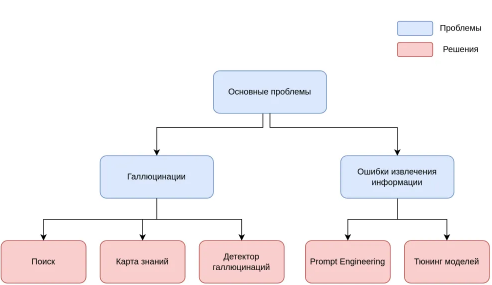

### Re-ranking

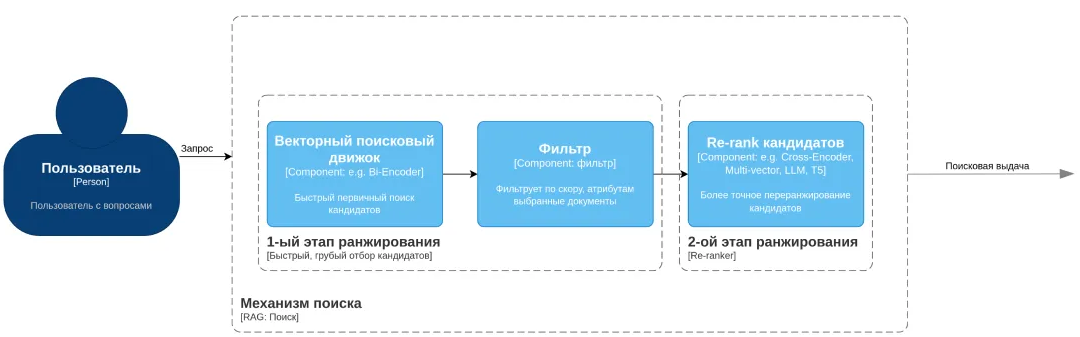




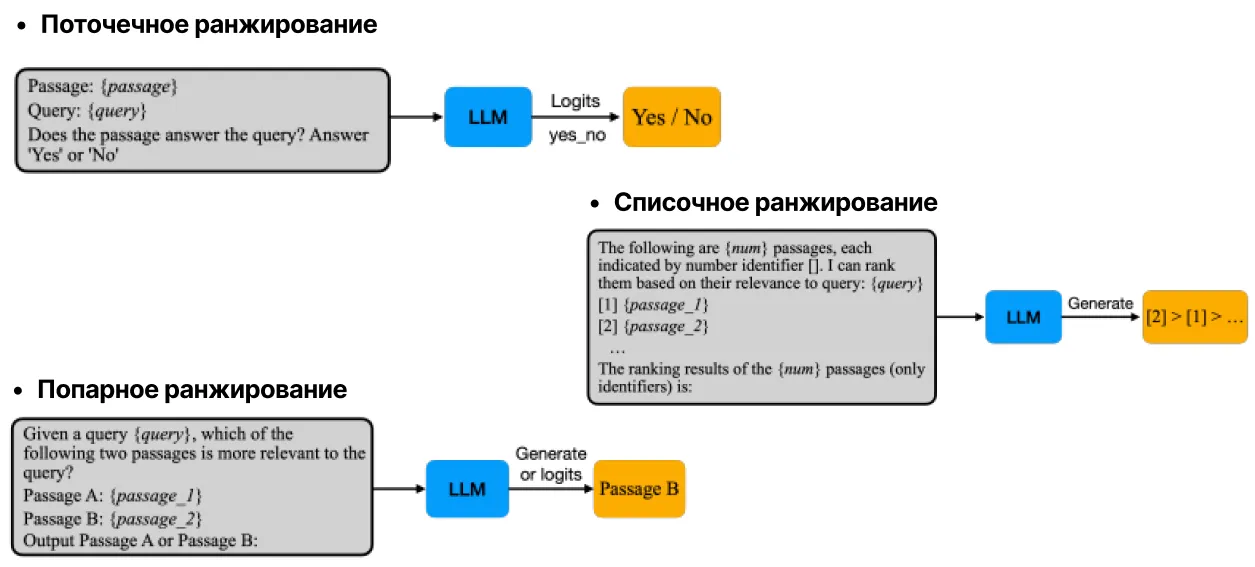

В качестве реранкера мы будем использовать специальную мультиязычную модель [amberoad/bert-multilingual-passage-reranking-msmarco](https://huggingface.co/amberoad/bert-multilingual-passage-reranking-msmarco), обученную для этих целей.

In [ ]:
cross_encoder = HuggingFaceCrossEncoder(
    model_name='amberoad/bert-multilingual-passage-reranking-msmarco',
    model_kwargs={'device': 'cuda' if torch.cuda.is_available() else 'cpu'}
)

config.json:   0%|          | 0.00/696 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/669M [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

In [ ]:
semantic_search(client, query, limit=50)

/tmp/ipython-input-18-1628058899.py:6: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  hits = client.search(


[{'text': '- Вы что — не смотрите на дорогу?\n\n- Почему же, смотрю: она отражается в Ваших глазах.\n\n«Безумно влюблённый» — еще одна замечательная, мною просмотренная комедия с легендарным Адриано Челентано. Видимо режиссерам и сценаристам Франко Кастеллано, Джузеппе Моччиа настолько понравилась экранная пара Адриано Челентано и Орнелла Мути, которая создалась в 1980 году в фильме «Укрощение строптивого», что они решили снять еще один фильм с этими потрясающими актерами. Только в этой картине наши герои поменялись местами, и теперь ухаживает и безумно влюбилась не Орнелла в Адрианно, который исполнял роль деревенского хама и грубияна Элию, а Адриано — обычный водитель автобуса по уши влюбился в прекрасную девушку-туристку, которая посетила его автобус, желая увидеть прекрасный город Рим.\n\n- Ты меня любишь?\n\n- Да.\n\n- Как?\n\n- До смерти.\n\n- Я думал больше.',
  'movie_name': 'Безумно влюбленный',
  'year': 1981},
 {'text': 'Наверное, всё-таки самый лучший фильм с участием Адриа

In [ ]:
def predict(query):
    selected_chunks = semantic_search(client, query, limit=50) + bm25_searcher.search(query, limit=50)

    texts = [f"Название: {chunk['movie_name']}. Отзыв: {chunk['text']}" for chunk in selected_chunks]
    scores = cross_encoder.score([(query, text) for text in texts])

    idxs = np.argsort(list(scores))[-10:]

    context = ' ; '.join([texts[i] for i in idxs])
    return llm_answer(query, context), context

In [ ]:
query = 'Какие мультфильмы были созданы студией Pixar'

In [ ]:
answer, context = predict(query)

print(answer)

/tmp/ipython-input-18-1628058899.py:6: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  hits = client.search(


Список основных мультфильмов, созданных студией Pixar:

1. "Как приручить дракона" (2005)
2. "Вверх" (2006)
3. "История игрушек" (2006)
4. "ВАЛЛ-И" (2008)
5. "История игрушек: Большой побег" (2010)
6. "ВАЛЛ-И" (2010)

Это всего лишь некоторые из наиболее известных и популярных мультфильмов студии Pixar.


In [ ]:
context.split(' ; ')

['Название: Как приручить дракона. Отзыв: Не для кого не секрет, что в природе существуют два короля компьютерной анимации: Pixar Animation Studio и DreamWorks Animation. И это не удивительно, ведь только у них получается выпускать поистине шедевральные, невероятно красивые да и просто потрясающие мультфильмы. Хотя нет, слово «мультфильмы» совершенно не вяжется с тем великолепием, которое мы видим на экранах наших кинотеатров. Здесь больше подходит слово «картины» или «полотна», ведь по своей художественной ценности они не уступают, а даже на несколько голов превосходят многие художественные киноленты, причём не только новичков в этом непростом деле, а даже некоторых опытных и заслуженных мастеров. Даже оскаровские академики уже оценили одного представителя молодого пока что жанра компьютерной анимации, номинировав «Вверх» (творение студии Pixar) в категории «Лучший полнометражный фильм». Не слабо, верно?',
 'Название: История игрушек Большой побег. Отзыв: Студия Pixar не устает по-хор

In [ ]:
query = 'В каких фильмах снимался Андриано Челентано?'
answer, context = predict(query)

print(answer)

/tmp/ipython-input-18-1628058899.py:6: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  hits = client.search(


Андриано Челентано снимался в следующих фильмах:

1. "Блеф" (1976)
2. "Укрощение строптивого" (1980)
3. "Блеф" (1976)
4. "Безумно влюбленный" (1981)
5. "Блеф" (1976)
6. "Укрощение строптивого" (1980)

Также стоит отметить, что в этих фильмах Челентано часто играет роль персонажей, которые вызывают сильное положительное влияние на зрителя, например, его образ "жёноненавистника" в фильме "Блеф".


In [ ]:
context.split(' ; ')

['Название: Блеф. Отзыв: Картина «Блеф» — яркий представитель жанра криминальной комедии. Снятый в 1976 году фильм уже давно стал бесспорной классикой. Лёгкий, местами наивный сюжет перенесёт нас в Европу тридцатых годов двадцатого века, где и приключилась история молодого амбициозного мошенника по имени Феликс.\n\nБезусловно, фильм не имел бы такой популярности, если бы не Адриано Челентано. Этот человек, без преувеличения, гений. «Блеф» стоит смотреть хотя бы ради его игры. Челентано виртуозен, харизматичен и крайне эмоционален. Вряд ли он кого то оставит равнодушным. Также стоит отметить Энтони Куинна. Он идеально подходит для своего героя Филиппа Бенга: опытного афериста, знающего толк в блефе. Их слаженный дуэт весь фильм радует зрителя своими авантюрами. Не стоит забывать и про прекрасную половину в лице Капюсин и Коринн Клери, своим обаянием их героини украшают картину.',
 'Название: Укрощение строптивого. Отзыв: Итальянский кинематограф всегда славился качественными фильмами, в

**Благодаря промпту модель не отвечает на вопрос, если в контексте нет нужной информации!**



In [ ]:
query = 'У какого фильма больше всего оскаров?'
answer, context = predict(query)

/tmp/ipython-input-18-1628058899.py:6: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  hits = client.search(


In [ ]:
print(answer)

Существует множество фильмов, которые были номинированы на несколько Оскаров. Однако, наиболее известное число, которое может быть приведено в качестве максимального количества, связано с фильмом "Пролетая над гнездом кукушки" (The Matrix), который получил 8 премий на общем счете 35. Этот фильм является одним из самых успешных в истории кинематографа и стал образцом для многих других фильмов.


### Multi-Query

В Multi-Query RAG LLM используется для автоматизации процесса тюнига промптов, чтобы генерировать несколько запросов с разных точек зрения для пользовательского вопроса.

Попробуем расширить контекст, добавив перефразированные вопросы.

Для перефразирования будем использовать ту же модель, которой генерируем текст, но с новым промптом.

In [ ]:
def rephrase_query(query, n=3):
    prompt = f"""
Твоя задача написать {n} разных вариаций вопроса пользователя для того,
чтобы по ним получить релевантные документы из векторной базы данных.
Ты должен переформулировать вопрос с разных точек зрения.
Это поможет избавить пользователя от недостатков поиска похожих документов на основе расстояния.
Вопрос пользователя сфокусирован на теме кино.
Напиши ТОЛЬКО вариации вопроса и больше ничего, разделяя их символом новой строки \\n.
НЕ пиши ответ на сам вопрос.
-----------------
{query}

"""
    messages = [
        {"role": "user", "content": prompt},
    ]
    output = generation_pipeline(messages, max_new_tokens=512, do_sample=True, temperature=0.9, top_p=0.7)
    queries = output[0]['generated_text'][1]['content']

    return re.split(r'\n+', queries)


def predict(query):
    queries = rephrase_query(query, n=3)

    # retrieve documents for each query
    all_chunks = []
    for rephrased_query in queries:
        selected_chunks = semantic_search(client, rephrased_query, limit=10) + bm25_searcher.search(query, limit=10)
        all_chunks.extend(selected_chunks)

    context = [f"Название: {chunk['movie_name']}. Отзыв: {chunk['text']}" for chunk in all_chunks]

    # rerank documents
    scores = cross_encoder.score([(query, text) for text in np.unique(context)])
    idxs = np.argsort(list(scores))[-10:]
    context = ' ; '.join([context[i] for i in idxs])

    # generate answer
    answer = llm_answer(query, context)

    return answer, context, queries

In [ ]:
query = 'Посоветуй легкую комедию'
answer, context, queries = predict(query)

/tmp/ipython-input-18-1628058899.py:6: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  hits = client.search(


In [ ]:
query

'Посоветуй легкую комедию'

In [ ]:
print(answer)

Советую вам просмотреть фильм "ЖАRА" (2006). Этот фильм является легкой комедией, которую вы сможете полностью посвятить своему вниманию. Он не слишком длинный и содержит достаточно веселья и юмора для вашего удовольствия. Фильм не требует от вас большого понимания сюжета или глубоких мыслей, поскольку он больше сосредоточен на удовольствии и развлечении. Важно отметить, что в этом фильме нет сюжета, который требует вашего внимания, и поэтому он идеально подходит для просмотра в свободное время.


Качество Multi-Query во многом зависит от способности LLM перефразировать текст. Если она справляется плохо, то появятся нерелевантные запросы. Это можно исправить, добавив фильтрацию по соответствию входному запросу.

In [ ]:
queries

['Пожалуйста, предложите мне легкую комедию.',
 'Какие фильмы можно посоветовать по теме кино?',
 'Я бы хотел посмотреть фильм, который можно посмотреть без особого внимания к деталям. Пожалуйста, предложите мне что-нибудь в этом роде.']

In [ ]:
context.split(' ; ')

['Название: Наша Russia Яйца судьбы. Отзыв: Если говорить проще, то какой фильм считается хорошим? Правильно! — Тот который запомнился вам и оставил под впечатлением надолго, вот и всё, что требуется от картины в целом. Не спецэффекты, не количество приглашённых звёзд, не огромная рекламная кампания, как пытаются навязать нам ушлые промоутеры. Всё это придаёт фильму статус кассового, но далеко не всегда делает его хорошим.',
 'Название: Босиком по мостовой (2005). Отзыв: Дополнительно отмечу великолепный, по моему мнению, саундтрек. Хороши как песни, так и просто музыкальные темы (композиции). Пусть некоторые песни и попсовые, но мне понравились, они, по моему мнению, отлично вписались в атмосферу и соответствующие эпизоды фильма. Один из первых саундтреков, которые я слушал и продолжаю слушать вне фильма.\n\nВ итоге имеем хорошую мелодраматическую комедию, пусть сопливую, наивную, но интересную, легкую, в то же время заставляющую задуматься, немного грустную, но оставляющую чувство ра

### Фильтры

Для некоторых видов запросов можно добавить фильтры, чтобы в контекст не могли попадать документы, которые однозначно не подходят.

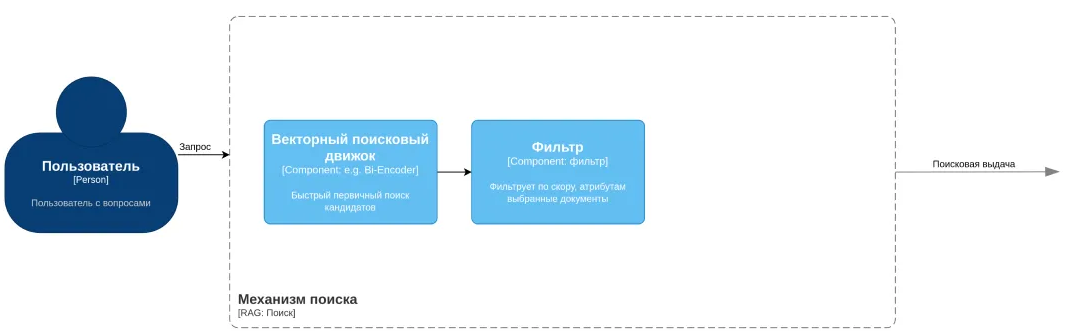

In [ ]:
def predict(query):
    selected_chunks = semantic_search(client, query, limit=10)
    context = ' ; '.join([
        f"Название: {chunk['movie_name']}. Год: {chunk['year']}. Отзыв: {chunk['text']}"
        for chunk in selected_chunks])

    return llm_answer(query, context), context

In [ ]:
query = 'Составь список шести лучших мелодрам 1980-х годов'

answer, context = predict(query)

/tmp/ipython-input-18-1628058899.py:6: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  hits = client.search(


In [ ]:
context

'Название: Братц. Год: 2007. Отзыв: Советую посмотреть. \n\n\n\n6 из 10 ; Название: Человеческая многоножка. Год: 2009. Отзыв: Я бы дал фильму 6 из 10 ; Название: В джазе только девушки. Год: 1959. Отзыв: Музыка 30-х, замечательные костюмы, шутки превратили это фильм в шедевр американской комедии 1950-х годов. Так что\n\n7 из 10 ; Название: Унесённые призраками. Год: 2001. Отзыв: Музыка. Она прекрасна. Она великолепна, отменна, превосходна, шедевральна, очаровательна, волшебна, умопомрачительна… Это можно продолжать до бесконечности! Я никогда не забуду «6 станцию», хотя, чего забывать? Я под неё частенько засыпаю!) В целом, музыка под стать фильму.\n\nПочувствовать, окунуться в мир, непонятный человеку. Мир, который человек считает диким. Прав ли этот человек? Вот какой вопрос ставит картина. Но в открытую не отвечает, хотя это и не нужно: ведь к концу мы уже сами понимаем, что быть вместе — значит быть счастливыми. И даже, если вы думаете, что совсем одни, знайте, что это неправда: в

In [ ]:
print(answer)

1. "Братцы" (2007) - советуют посмотреть.
2. "Человеческая многоножка" (2009) - 6/10.
3. "В джазе только девушки" (1959) - 7/10; замечательная музыка и юмор.
4. "Унесенные призраками" (2001) - 10/10; великолепная музыка.
5. "Шерлок Холмс" (2009) - 8/10; комедия с классическим решением.
6. "Остров проклятых" (2009) - 10/10; в десятке самых любимых фильмов.
7. "Возвращение мушкетеров" (2008) - 10/10; шедевр фэнтези с классическими элементами.
8. "Звездный десант 3 Мародер" (2008) - 8/10; отличное сочетание комедии и триллера.
9. "Назад в будущее 2" (1989) - 8/10; продолжение классического фантастического фильма 80-х.
10. "В джазе только девушки" (1959) - 10/10; за безупречную игру актеров, интересный сюжет и много позитивных моментов.


В этом примере модель сгенерировала не только не мелодрамы, но и фильмы неверных лет:

In [ ]:
def filtered_semantic_search(client, query, filter_years, limit=10):
    query_vector = embedding_model.encode(
        query, normalize_embeddings=True, device=device
    ).tolist()

    begin, end = filter_years
    hits = client.search(
        collection_name="kinopoisk_e5",
        query_vector=query_vector,
        limit=limit,
        query_filter=models.Filter(
            must=[models.FieldCondition(key="year", range=models.Range(gte=begin, lte=end))]
        ),
    )
    relevant_chunks = [hit.payload for hit in hits]

    return relevant_chunks

def predict(query, filter_years=None):
    if filter_years is not None:
        selected_chunks = filtered_semantic_search(client, query, filter_years=filter_years, limit=10)
    else:
        selected_chunks = semantic_search(client, query, limit=10)

    context = ' ; '.join([f"Название: {chunk['movie_name']}. Год: {chunk['year']}. Отзыв: {chunk['text']}" for chunk in selected_chunks])

    return llm_answer(query, context), context

In [ ]:
answer, context = predict(query, filter_years=(1980, 1989))

/tmp/ipython-input-58-4289898432.py:7: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  hits = client.search(


In [ ]:
print(answer)

Список шести лучших мелодрам 1980-х годов:

1. "Клуб "Завтрак" - Название: Клуб "Завтрак". Год: 1985.
   Отзыв: Замечательный фильм, пожалуй, лучший в своем жанре.

2. "Лицо со шрамом" - Название: Лицо со шрамом. Год: 1983.
   Отзыв: Куда катится наш российский кинематограф в последнее время?

3. "Ганди" - Название: Ганди. Год: 1982.
   Отзыв: Фильм, который из-за большой продолжительности трудно будет пересматривать часто, но который, безусловно, является шедевром мирового кинематографа и одной из лучших картин 80-х годов.

4. "Крепкий орешек" - Название: Крепкий орешек. Год: 1988.
   Отзыв: Качественный и качественный фильм, который оставит深刻的 впечатление на зрителя.

5. "Клуб "Завтрак" - Название: Клуб "Завтрак". Год: 1985.
   Отзыв: Замечательный фильм, пожалуй, лучший в своем жанре.

6. "Любовь и голуби" - Название: Любовь и голуби. Год: 1984.
   Отзыв: Куда катится наш российский кинематограф в последнее время?


In [ ]:
print(context)

Название: Назад в будущее 2. Год: 1989. Отзыв: На мой взгляд — гениальное продолжение одного из лучших фантастических приключенческих фильмов 80-х. Пересматривать можно бесконечно! ; Название: Человек дождя. Год: 1988. Отзыв: Восемь. Сцена в лифте. Вершина тогдашнего кинематографа. Лишний повод показать любителям эротических сцен, как надо работать. Ёмко, компактно, увесисто.

Девять. Отсутствие кетчупа. И даже поводов для него. Для голливудщины это оригинальность высшего класса.

Сегодня, безусловно, так не снимают хотя бы потому, что 80-ые ушли. ; Название: Ганди. Год: 1982. Отзыв: Фильм, который из-за большой продолжительности трудно будет пересматривать часто, но который, безусловно, является шедевром мирового кинематографа и одной из лучших картин 80-х годов. Советую смотреть в советском дубляже.

9 из 10 ; Название: Клуб «Завтрак». Год: 1985. Отзыв: И пожалуй это лучшее кино в этом жанре.

10 из 10 ; Название: Лицо со шрамом. Год: 1983. Отзыв: 8 из 10 ; Название: Крепкий орешек. 

# Итоги:

Мы рассмотрели техники (multi-query), алгоритмы (bm25) и модели (cross-encoders), которые позволяют повысить качество базового поиска и вместе с ним — качество вашей RAG-системы.